# Load Modules

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd '/content/drive/My Drive/2019- Zehao'

/content/drive/My Drive/2019- Zehao


In [0]:
!pip install scikit-multilearn

     |████████████████████████████████| 92kB 7.4MB/s 


In [0]:
print("Importing modules...")
import numpy as np
import pandas as pd
import scipy
import sklearn
import skmultilearn
from sklearn.metrics import (accuracy_score, precision_score, f1_score, recall_score, hamming_loss, zero_one_loss)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.problem_transform import ClassifierChain
print("...Complete")

Importing modules...
...Complete


# Define functions

In [0]:
def unpivot_y(y, df=False):
  y_flat = y.unstack().reset_index(name='value')
  y_flat.rename(columns={'level_0': 'class'}, inplace=True)
  return y_flat.groupby('class')[['value']].sum() if df==True else y_flat.groupby('class')['value'].sum()

In [0]:
def set_problem_transformation(clf, method):
    """
    ====================================================================================
                                  Set Problem Transformation
    ====================================================================================
    Key arguments:
        clf     =  scikit-learn classifier (e.g. RandomForestClassifier())
        method  =  scikit-multilearn problem transformation method among the ones below:
        
                   'BR' = BinaryRelevance()
                   'LP' = LabelPowerset()
                   'CC' = ClassifierChain()
    ====================================================================================
    """
    # define methods
    methods = {'BR' : BinaryRelevance(classifier=clf, require_dense=[True,True]),
               'LP' : LabelPowerset(classifier=clf, require_dense=[True,True]),
               'CC' : ClassifierChain(classifier=clf, require_dense=[True,True])}
    
    # set the problem transformation
    if method in methods.keys():
        pt_clf = methods[method]
        return pt_clf
    else:
        return str(method)+" is not contained among the possible methods (Try to use 'BR', 'LP', or 'CC')"

In [0]:
def metrics_problem_transformation(pt_clf, X_train, y_train, X_test, y_test):
    """
    ====================================================================================
                                  Test Problem Transformation
    ====================================================================================
    Key arguments:
        pt_clf   =  scikit-multilearn problem transformation classifier
        X_train  =  pandas dataframe containing the training set values
        y_train  =  pandas dataframe containing the training set labels
        X_test   =  pandas dataframe containing the test set values
        y_test   =  pandas dataframe containing the test set labels
    ====================================================================================
    """    
    # load modules
    import pandas as pd
    from sklearn.metrics import (accuracy_score, precision_score, f1_score, recall_score, hamming_loss, zero_one_loss)
    
    # train
    print("Fitting the function...")
    pt_clf.fit(X_train, y_train)
    print("...Complete")
    
    # predict and convert
    print("Predicting the entries...")
    y_pred = pt_clf.predict(X_test)
    print("...Complete\n")
    y_pred = y_pred.todense(order=None, out=None)
    y_pred = pd.DataFrame(y_pred, index=y_test.index.values, columns=y_test.columns.values)
    
    return y_pred
  
def get_metrics(y_test, y_pred):  
    # metrics
    accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
    hloss = sklearn.metrics.hamming_loss(y_test, y_pred)
    zero_one_loss = sklearn.metrics.zero_one_loss(y_test, y_pred)
    micro_precision = sklearn.metrics.precision_score(y_test, y_pred, average='micro')
    weighted_precision = sklearn.metrics.precision_score(y_test, y_pred, average='weighted')
    micro_recall = sklearn.metrics.recall_score(y_test, y_pred, average='micro')
    weighted_recall = sklearn.metrics.recall_score(y_test, y_pred, average='weighted')
    macro_f1 = sklearn.metrics.f1_score(y_test, y_pred, average='macro')
    micro_f1 = sklearn.metrics.f1_score(y_test, y_pred, average='micro')
    weighted_f1 = sklearn.metrics.f1_score(y_test, y_pred, average='weighted')
    report =  sklearn.metrics.classification_report(y_test, y_pred,output_dict=True)

    # list metrics and round them
    metrics = [accuracy, hloss, zero_one_loss, micro_recall, weighted_recall,
              micro_precision, weighted_precision, macro_f1, micro_f1, weighted_f1]
    rnd_metrics =  [round(x,2) for x in metrics]
    
    details={}
    #find lables that has 0 TP prediction 
    repo = round(pd.DataFrame(report),2).T['f1-score']
    details['noTPLabel'] = len(repo[repo==0])
    noTPLabels = [int(x) for x in list(repo[repo==0].index)]
    #confusion[confusion==0].count().where(lambda x : x==0).dropna() #same results

    #count predicted labels number per entry
    rows_pred = y_pred[y_pred==1].T.count() 
    details['minLabelRow'] = rows_pred.min()
    details['medLabelRow'] = rows_pred.median()
    details['meanLabelRow'] = rows_pred.mean()
    details['maxLabelRow'] = rows_pred.max()
    details['noLabelRow'] = rows_pred[rows_pred==0].count()
    
    #count value in confusion matrix
    y_pred[y_pred==0]=-1
    confusion = y_test-y_pred
    details['TP'] = confusion[confusion==0].count().sum()
    details['FN'] = confusion[confusion==2].count().sum()
    details['FP'] = confusion[confusion==-1].count().sum()
    details['TN'] = confusion[confusion==1].count().sum()

    #print (pt_clf)
    print(str(pt_clf).split('(')[0:2])
    print (rnd_metrics)
#     print (round(pd.DataFrame(report),2).T)
    return metrics, details, noTPLabels

 # define rf classifier
rf = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, 
                                min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=4, 
                                random_state=11, verbose=0, warm_start=False, class_weight=None)

    # define svm classifier
svm = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, 
                    C=1.0, multi_class='ovr', fit_intercept=True, intercept_scaling=1, 
                    class_weight=None, verbose=0, random_state=11, max_iter=1000)

# Train all models, and generate all metrics

In [0]:
#generate all metrics
from warnings import filterwarnings
filterwarnings('ignore')
from skmultilearn.model_selection import iterative_train_test_split
from collections import Counter
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
from scipy import stats
# Top5, Top10, Top15, Top20, Top25, Top50, FCFP0, FCFP2, FCFP4
# FRINGERPRINTS = ["Top5", "Top10", "Top15", "Top20", "Top25", "Top50"]
FRINGERPRINTS = [ 'FCFP0', 'FCFP2', 'FCFP4']  # for FCFP
all_noTPLabels, MinRC,MeanRC,MedRC,MaxRC = [],[],[],[],[]
df_details = pd.DataFrame()
for FINGERPRINT in FRINGERPRINTS:
    np.random.seed(0)
#     PATH = "{0}_Fingerprint".format(FINGERPRINT) #{0}_Fingerprint for Top class FP folder
    PATH = "CDK-{0}".format(FINGERPRINT) #CDK_{0} for FCFP folder
    print("Loading {}...".format(FINGERPRINT))
#     df = pd.read_csv("{0}/{1}.csv.gz".format(PATH,FINGERPRINT), compression='gzip')
    df = pd.read_csv("{0}/{1}.csv".format(PATH,FINGERPRINT))  # for FCFP 
    
    df = df.reindex(sorted(df.columns), axis=1) # sort columns by name
    X = df.filter(like='bit', axis=1)  #select rows containing 'bit' 
    y = df[df.columns.drop(list(df.filter(regex='bit|StringFP|row ID')))] #remove columns containing 'bit' and RowID

    X_train, y_train, X_test, y_test = iterative_train_test_split(np.array(X), np.array(y), test_size = 0.2)
    #stratified sampling http://scikit.ml/stratification.html
    
    # add index values
    y_train = pd.DataFrame(y_train)
    y_test = pd.DataFrame(y_test)
    y_test.columns, y_train.columns = y.columns,y.columns
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)
    X_test.columns, X_train.columns = X.columns,X.columns
    
#     classPair = pd.DataFrame({
#       'train': Counter(str(combination) for row in get_combination_wise_output_matrix(np.array(y_train), order=2) for combination in row),
#       'test' : Counter(str(combination) for row in get_combination_wise_output_matrix(np.array(y_test), order=2) for combination in row)
#     }).fillna(0.0)
#     print("Train/Test distribution difference:",np.absolute(classPair['train']/0.8 - classPair['test']/0.2).mean())
#     print("KS-test:",stats.ks_2samp(unpivot_y(y_train)/0.8,unpivot_y(y_test)/0.2))
    
    methods_to_test = ['BR', 'CC', 'LP']
    classifiers_to_test = [rf, svm]
    error = []
    #f = open("ALL_Metrics_New.csv", "a+")
    #f.write("{},,,,,,,,,,,".format(FINGERPRINT)+"\n")
    #f.write("method,classifier,accuracy, hloss, zero_one_loss, micro_recall, weighted_recall, micro_precision, weighted_precision, macro_f1, micro_f1, weighted_f1"+"\n")
    for c in classifiers_to_test:
        for m in methods_to_test:
#             try:
                pt_clf = set_problem_transformation(c, m)
                y_pred = metrics_problem_transformation(pt_clf, X_train, y_train, X_test, y_test)
                metrics, details, noTPLabels = get_metrics(y_test, y_pred)
                all_noTPLabels.extend(noTPLabels)
                details['method'] = m
                details['classifier'] = 'RF' if str(c).split('(')[0]=='RandomForestClassifier' else 'SVM'
                
                df_details = df_details.append(details,ignore_index=True)
                
                # append metrics into file
                #f.write(','.join([m,str(c).split('(')[0],','.join(map(str, [round(x,2) for x in metrics]))])+"\n")
#             except Exception as e:
#                 error.append(e)
#                 pass
    #f.write(",,,,,,,,,,,"+"\n")
    #f.close()

    print("\n")
# df_details.to_csv("Fingerprints_Attr_temp3.csv")

Loading FCFP0...
Fitting the function...
...Complete
Predicting the entries...
...Complete

['BinaryRelevance', 'classifier=RandomForestClassifier']
[0.02, 0.23, 0.98, 0.43, 0.43, 0.48, 0.49, 0.38, 0.46, 0.44]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['ClassifierChain', 'classifier=RandomForestClassifier']
[0.0, 0.21, 1.0, 0.18, 0.18, 0.55, 0.49, 0.2, 0.27, 0.25]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['LabelPowerset', 'classifier=RandomForestClassifier']
[0.0, 0.33, 1.0, 0.54, 0.54, 0.34, 0.36, 0.35, 0.42, 0.42]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['BinaryRelevance', 'classifier=LinearSVC']
[0.02, 0.14, 0.98, 0.62, 0.62, 0.71, 0.72, 0.65, 0.66, 0.66]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['ClassifierChain', 'classifier=LinearSVC']
[0.02, 0.15, 0.98, 0.58, 0.58, 0.69, 0.7, 0.62, 0.63, 0.62]
Fitting the function...
...Complete
Predicting the e

In [0]:
df_noTPLabel = pd.DataFrame([{0: 1,
 1: 13,
 2:0,
 3: 10,
 4: 2,
 5: 5,6:0,
 7: 17,8:0,9:0,
 10: 4,11:0,
 12: 4,13:0,
 14: 10,
 15: 2,16:0,
 17: 1,
 18: 2,
 19: 14,
 20: 8,
 21: 2,
 22: 7,
 23: 1,
 24: 10,25:0,
 26: 1,
 27: 4,
 28: 3,
 29: 13,
 30: 14,31:0,
 32: 12,33:0,34:0,
 35: 1,36:0}])

In [0]:
df_noTPLabel.columns=y.columns
df_noTPLabel.T.sort_values(by=0,ascending=False).T

,C-N Bond Formation (N-acetylation),Functional Conversion (Hydroxy to methoxy),Functional Introduction (Nitration),Functional Introduction (Iodination),C-C Bond Formation (Condensation),Protection (O-Acetyl),Functional Elimination (Debromination),C-C Bond Formation (Methylation),Cleavage (Hydrolysis),Functional Conversion (Oxidation),Functional Conversion (Reduction),C-N Bond Formation (Amination),C-N Bond Formation (N-methylation),C-O Bond Formation (Esterification),Functional Introduction (Bromination),Functional Introduction (Hydroxylation),Deprotection (N-Benzyl),C-C Bond Formation (Olefination),Functional Conversion (Pyridone to chloropyridine),Functional Conversion (Cyano to carbamoyl),Functional Elimination (Deoxygenation),Functional Conversion (Sulfanyl to sulfinyl),Synthesis (Thiazole),C-C Bond Formation (Acylation),Functional Conversion (Alcohol to alkene),Functional Elimination (Decarboxylation),Deprotection (N-t-Butyloxycarbonyl),C-O Bond Formation (Etherification),C-N Bond Formation (Urea formation),C-N Bond Formation (N-arylation),C-N Bond Formation (N-alkylation),Other Bond Formation (Sulfonamide formation),C-N Bond Formation (Condensation),Synthesis (1-2-4-Oxadiazole),Synthesis (Pyrazole),C-C Bond Formation (Coupling),Synthesis (Thioether)
0,17,14,14,13,13,12,10,10,10,8,7,5,4,4,4,3,2,2,2,2,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0


# Top 5, 10, 15, 20, 25, 50 Class FP Results 


```

*   Loading Top5...

Train/Test difference: 40.796636085626915
Train/Test distribution difference: 4.248853211009174
Fitting the function...
...Complete
Predicting the entries...
...Complete

['BinaryRelevance', 'classifier=RandomForestClassifier']
[0.14, 0.04, 0.86, 0.19, 0.19, 0.4, 0.38, 0.23, 0.26, 0.25]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['ClassifierChain', 'classifier=RandomForestClassifier']
[0.17, 0.04, 0.83, 0.2, 0.2, 0.47, 0.42, 0.24, 0.28, 0.26]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['LabelPowerset', 'classifier=RandomForestClassifier']
[0.22, 0.06, 0.78, 0.32, 0.32, 0.29, 0.3, 0.28, 0.3, 0.31]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['BinaryRelevance', 'classifier=LinearSVC']
[0.13, 0.04, 0.87, 0.12, 0.12, 0.69, 0.39, 0.16, 0.2, 0.17]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['ClassifierChain', 'classifier=LinearSVC']
[0.16, 0.04, 0.84, 0.15, 0.15, 0.61, 0.39, 0.19, 0.24, 0.19]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['LabelPowerset', 'classifier=LinearSVC']
[0.28, 0.05, 0.72, 0.37, 0.37, 0.33, 0.33, 0.31, 0.35, 0.34]

    *   Loading Top10...
Train/Test difference: 40.91940789473684
Train/Test distribution difference: 3.233963815789474
Fitting the function...
...Complete
Predicting the entries...
...Complete

['BinaryRelevance', 'classifier=RandomForestClassifier']
[0.14, 0.04, 0.86, 0.19, 0.19, 0.41, 0.41, 0.23, 0.26, 0.25]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['ClassifierChain', 'classifier=RandomForestClassifier']
[0.17, 0.03, 0.83, 0.2, 0.2, 0.45, 0.42, 0.24, 0.28, 0.26]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['LabelPowerset', 'classifier=RandomForestClassifier']
[0.25, 0.05, 0.75, 0.34, 0.34, 0.29, 0.31, 0.28, 0.31, 0.31]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['BinaryRelevance', 'classifier=LinearSVC']
[0.15, 0.03, 0.85, 0.14, 0.14, 0.66, 0.49, 0.18, 0.23, 0.19]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['ClassifierChain', 'classifier=LinearSVC']
[0.22, 0.03, 0.78, 0.21, 0.21, 0.52, 0.54, 0.25, 0.3, 0.25]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['LabelPowerset', 'classifier=LinearSVC']
[0.31, 0.05, 0.69, 0.39, 0.39, 0.33, 0.32, 0.32, 0.35, 0.35]

      *    Loading Top15...
Train/Test difference: 42.84929078014184
Train/Test distribution difference: 2.7836879432624113
Fitting the function...
...Complete
Predicting the entries...
...Complete

['BinaryRelevance', 'classifier=RandomForestClassifier']
[0.16, 0.03, 0.84, 0.19, 0.19, 0.45, 0.43, 0.23, 0.27, 0.26]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['ClassifierChain', 'classifier=RandomForestClassifier']
[0.18, 0.03, 0.82, 0.21, 0.21, 0.47, 0.45, 0.25, 0.29, 0.27]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['LabelPowerset', 'classifier=RandomForestClassifier']
[0.29, 0.04, 0.71, 0.35, 0.35, 0.31, 0.34, 0.3, 0.33, 0.33]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['BinaryRelevance', 'classifier=LinearSVC']
[0.16, 0.03, 0.84, 0.15, 0.15, 0.69, 0.54, 0.2, 0.24, 0.2]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['ClassifierChain', 'classifier=LinearSVC']
[0.25, 0.03, 0.75, 0.24, 0.24, 0.43, 0.48, 0.26, 0.31, 0.27]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['LabelPowerset', 'classifier=LinearSVC']
[0.34, 0.04, 0.66, 0.4, 0.4, 0.35, 0.34, 0.34, 0.37, 0.36]
Loading Top20...
Train/Test difference: 45.934489402697494
Train/Test distribution difference: 2.627649325626204
Fitting the function...
...Complete
Predicting the entries...
...Complete

['BinaryRelevance', 'classifier=RandomForestClassifier']
[0.16, 0.03, 0.84, 0.19, 0.19, 0.47, 0.45, 0.25, 0.27, 0.26]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['ClassifierChain', 'classifier=RandomForestClassifier']
[0.19, 0.03, 0.81, 0.21, 0.21, 0.49, 0.47, 0.25, 0.29, 0.28]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['LabelPowerset', 'classifier=RandomForestClassifier']
[0.28, 0.04, 0.72, 0.33, 0.33, 0.31, 0.33, 0.29, 0.32, 0.32]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['BinaryRelevance', 'classifier=LinearSVC']
[0.17, 0.03, 0.83, 0.16, 0.16, 0.69, 0.5, 0.22, 0.26, 0.22]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['ClassifierChain', 'classifier=LinearSVC']
[0.28, 0.04, 0.72, 0.27, 0.27, 0.31, 0.47, 0.28, 0.29, 0.28]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['LabelPowerset', 'classifier=LinearSVC']
[0.36, 0.04, 0.64, 0.41, 0.41, 0.36, 0.36, 0.35, 0.39, 0.38]

      *    Loading Top25...
Train/Test difference: 47.082
Train/Test distribution difference: 2.79
Fitting the function...
...Complete
Predicting the entries...
...Complete

['BinaryRelevance', 'classifier=RandomForestClassifier']
[0.16, 0.03, 0.84, 0.18, 0.18, 0.45, 0.44, 0.23, 0.26, 0.25]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['ClassifierChain', 'classifier=RandomForestClassifier']
[0.18, 0.03, 0.82, 0.2, 0.2, 0.47, 0.46, 0.25, 0.28, 0.27]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['LabelPowerset', 'classifier=RandomForestClassifier']
[0.29, 0.04, 0.71, 0.35, 0.35, 0.31, 0.34, 0.31, 0.33, 0.33]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['BinaryRelevance', 'classifier=LinearSVC']
[0.16, 0.03, 0.84, 0.16, 0.16, 0.68, 0.61, 0.23, 0.26, 0.22]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['ClassifierChain', 'classifier=LinearSVC']
[0.28, 0.04, 0.72, 0.28, 0.28, 0.32, 0.53, 0.29, 0.3, 0.3]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['LabelPowerset', 'classifier=LinearSVC']
[0.35, 0.04, 0.65, 0.42, 0.42, 0.35, 0.36, 0.36, 0.38, 0.38]
              *   Loading Top50...
Train/Test difference: 51.59111111111111
Train/Test distribution difference: 2.488888888888889
Fitting the function...
...Complete
Predicting the entries...
...Complete

['BinaryRelevance', 'classifier=RandomForestClassifier']
[0.16, 0.03, 0.84, 0.19, 0.19, 0.48, 0.46, 0.23, 0.27, 0.25]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['ClassifierChain', 'classifier=RandomForestClassifier']
[0.17, 0.03, 0.83, 0.19, 0.19, 0.49, 0.47, 0.24, 0.28, 0.26]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['LabelPowerset', 'classifier=RandomForestClassifier']
[0.3, 0.04, 0.7, 0.35, 0.35, 0.32, 0.34, 0.3, 0.33, 0.33]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['BinaryRelevance', 'classifier=LinearSVC']
[0.2, 0.03, 0.8, 0.2, 0.2, 0.65, 0.58, 0.28, 0.3, 0.27]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['ClassifierChain', 'classifier=LinearSVC']
[0.31, 0.04, 0.69, 0.31, 0.31, 0.36, 0.48, 0.32, 0.34, 0.33]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['LabelPowerset', 'classifier=LinearSVC']
[0.36, 0.04, 0.64, 0.41, 0.41, 0.36, 0.37, 0.36, 0.38, 0.38]

```





---


# FCFP0, 2, 4 Results


```
Loading FCFP0...
Train/Test distribution difference: 7.510668563300142
KS-test: Ks_2sampResult(statistic=0.13513513513513514, pvalue=0.8944468869217319)
Fitting the function...
...Complete
Predicting the entries...
...Complete

['BinaryRelevance', 'classifier=RandomForestClassifier']
[0.02, 0.23, 0.98, 0.43, 0.43, 0.48, 0.49, 0.38, 0.46, 0.44]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['ClassifierChain', 'classifier=RandomForestClassifier']
[0.0, 0.21, 1.0, 0.18, 0.18, 0.55, 0.49, 0.2, 0.27, 0.25]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['LabelPowerset', 'classifier=RandomForestClassifier']
[0.0, 0.33, 1.0, 0.54, 0.54, 0.34, 0.36, 0.35, 0.42, 0.42]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['BinaryRelevance', 'classifier=LinearSVC']
[0.02, 0.14, 0.98, 0.62, 0.62, 0.71, 0.72, 0.65, 0.66, 0.66]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['ClassifierChain', 'classifier=LinearSVC']
[0.02, 0.15, 0.98, 0.58, 0.58, 0.69, 0.7, 0.62, 0.63, 0.62]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['LabelPowerset', 'classifier=LinearSVC']
[0.0, 0.16, 1.0, 0.55, 0.55, 0.65, 0.68, 0.58, 0.6, 0.59]
Loading FCFP2...
Train/Test distribution difference: 2.5594059405940595
KS-test: Ks_2sampResult(statistic=0.02702702702702703, pvalue=1.0)
Fitting the function...
...Complete
Predicting the entries...
...Complete

['BinaryRelevance', 'classifier=RandomForestClassifier']
[0.12, 0.03, 0.88, 0.14, 0.14, 0.5, 0.46, 0.18, 0.22, 0.21]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['ClassifierChain', 'classifier=RandomForestClassifier']
[0.14, 0.03, 0.86, 0.15, 0.15, 0.5, 0.47, 0.2, 0.23, 0.22]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['LabelPowerset', 'classifier=RandomForestClassifier']
[0.29, 0.04, 0.71, 0.34, 0.34, 0.31, 0.33, 0.29, 0.32, 0.32]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['BinaryRelevance', 'classifier=LinearSVC']
[0.11, 0.03, 0.89, 0.11, 0.11, 0.69, 0.48, 0.17, 0.18, 0.17]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['ClassifierChain', 'classifier=LinearSVC']
[0.2, 0.03, 0.8, 0.2, 0.2, 0.36, 0.43, 0.23, 0.26, 0.23]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['LabelPowerset', 'classifier=LinearSVC']
[0.34, 0.04, 0.66, 0.39, 0.39, 0.35, 0.34, 0.32, 0.37, 0.36]
Loading FCFP4...
Train/Test distribution difference: 2.294188861985472
KS-test: Ks_2sampResult(statistic=0.05405405405405406, pvalue=0.9999999999212894)
Fitting the function...
...Complete
Predicting the entries...
...Complete

['BinaryRelevance', 'classifier=RandomForestClassifier']
[0.12, 0.03, 0.88, 0.13, 0.13, 0.61, 0.53, 0.18, 0.21, 0.19]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['ClassifierChain', 'classifier=RandomForestClassifier']
[0.13, 0.03, 0.87, 0.14, 0.14, 0.62, 0.55, 0.19, 0.22, 0.21]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['LabelPowerset', 'classifier=RandomForestClassifier']
[0.34, 0.04, 0.66, 0.36, 0.36, 0.36, 0.36, 0.31, 0.36, 0.35]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['BinaryRelevance', 'classifier=LinearSVC']
[0.17, 0.03, 0.83, 0.19, 0.19, 0.5, 0.47, 0.28, 0.28, 0.25]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['ClassifierChain', 'classifier=LinearSVC']
[0.27, 0.04, 0.73, 0.28, 0.28, 0.31, 0.37, 0.3, 0.3, 0.29]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['LabelPowerset', 'classifier=LinearSVC']
[0.31, 0.04, 0.69, 0.36, 0.36, 0.33, 0.34, 0.34, 0.34, 0.34]
```




---

# Train / Test Distribution KS-test & Labels Distribution

ref: https://link.springer.com/chapter/10.1007/978-3-642-23808-6_10



```
Loading Top5...
Radom Split: 
Train/Test KS-test statistic=0.08108108108108109 p value:0.9998280831475461
Labels Distribution: 0.001581450636833289
Stratification: 
Train/Test KS-test statistic=0.05405405405405406 p value:0.9999999999212894
Labels Distribution: 0.0009106416531988534


Loading Top10...
Radom Split: 
Train/Test KS-test statistic=0.08108108108108109 p value:0.9998280831475461
Labels Distribution: 0.0009754641049838228
Stratification: 
Train/Test KS-test statistic=0.02702702702702703 p value:1.0
Labels Distribution: 3.561206870809016e-05


Loading Top15...
Radom Split: 
Train/Test KS-test statistic=0.08108108108108109 p value:0.9998280831475461
Labels Distribution: 0.0009808446494315567
Stratification: 
Train/Test KS-test statistic=0.05405405405405406 p value:0.9999999999212894
Labels Distribution: 9.592266304955413e-05


Loading Top20...
Radom Split: 
Train/Test KS-test statistic=0.08108108108108109 p value:0.9998280831475461
Labels Distribution: 0.0009796975266340875
Stratification: 
Train/Test KS-test statistic=0.02702702702702703 p value:1.0
Labels Distribution: 3.4939389545918883e-05


Loading Top25...
Radom Split: 
Train/Test KS-test statistic=0.13513513513513514 p value:0.8944468869217319
Labels Distribution: 0.0010273258617989785
Stratification: 
Train/Test KS-test statistic=0.02702702702702703 p value:1.0
Labels Distribution: 8.391831154120359e-05


Loading Top50...
Radom Split: 
Train/Test KS-test statistic=0.08108108108108109 p value:0.9998280831475461
Labels Distribution: 0.0007314007216420832
Stratification: 
Train/Test KS-test statistic=0.05405405405405406 p value:0.9999999999212894
Labels Distribution: 4.2734576973612104e-05

Loading FCFP0...
Radom Split: 
Train/Test KS-test statistic=0.16216216216216217 p value:0.7227565530633371
Labels Distribution: 0.03600143996103518
Stratification: 
Train/Test KS-test statistic=0.13513513513513514 p value:0.8944468869217319
Labels Distribution: 0.032362657022738384


Loading FCFP2...
Radom Split: 
Train/Test KS-test statistic=0.08108108108108109 p value:0.9998280831475461
Labels Distribution: 0.0009453178559675603
Stratification: 
Train/Test KS-test statistic=0.02702702702702703 p value:1.0
Labels Distribution: 5.89502626770884e-05


Loading FCFP4...
Radom Split: 
Train/Test KS-test statistic=0.10810810810810811 p value:0.9845599548024895
Labels Distribution: 0.0010890773239767837
Stratification: 
Train/Test KS-test statistic=0.05405405405405406 p value:0.9999999999212894
Labels Distribution: 3.247860440000621e-05

```



In [0]:
def labelDistribution(train,test,y_length):
    class_distr = pd.DataFrame({'TrainCounts':unpivot_y(train), 'TestCounts': unpivot_y(test) })
    class_distr['full'] = class_distr['TrainCounts'] + class_distr['TestCounts']
    class_distr['train_diff'] = np.absolute((class_distr['TrainCounts']/(train.shape[0]-class_distr['TrainCounts']) - class_distr['full']/(y_length-class_distr['full'])))
    class_distr['test_diff'] = np.absolute((class_distr['TestCounts']/(test.shape[0]-class_distr['TestCounts']) - class_distr['full']/(y_length-class_distr['full'])))
    class_distr['Labels Distribution'] = class_distr[['train_diff','test_diff']].mean(axis=1)
    return class_distr['Labels Distribution'].mean()

In [0]:
#check stratification split distribution 
from warnings import filterwarnings
filterwarnings('ignore')
from skmultilearn.model_selection import iterative_train_test_split
from collections import Counter
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
from scipy import stats
# "Top5", "Top10", "Top15", "Top20", "Top25", "Top50" FCFP0, FCFP2, FCFP4
FRINGERPRINTS = ["Top5", "Top10", "Top15", "Top20", "Top25", "Top50"]
# FRINGERPRINTS = [ 'FCFP0', 'FCFP2', 'FCFP4']  # for FCFP
f = open("Tran_Test_KS1.csv", "a+")
# f.write("Fingerprint,Split Method,Kolmogorov-Smirnov Test Statistic,p value,Labels Distribution,Example Distribution,Train,Test \n")
for FINGERPRINT in FRINGERPRINTS:
    np.random.seed(0)
    PATH = "{0}_Fingerprint".format(FINGERPRINT) #{0}_Fingerprint for Top class FP folder
#     PATH = "CDK-{0}".format(FINGERPRINT) #CDK_{0} for FCFP folder
    print("Loading {}...".format(FINGERPRINT))
    df = pd.read_csv("{0}/{1}.csv.gz".format(PATH,FINGERPRINT), compression='gzip')
#     df = pd.read_csv("{0}/{1}.csv".format(PATH,FINGERPRINT))  # for FCFP
    
    df = df.reindex(sorted(df.columns), axis=1) # sort columns by name
    X = df.filter(like='bit', axis=1)  #select rows containing 'bit' 
    y = df[df.columns.drop(list(df.filter(regex='bit|StringFP|row ID')))] #remove columns containing 'bit' and RowID
    
    print("Radom Split: ")
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size = 0.2, random_state=0)
    ks1 = stats.ks_2samp(unpivot_y(y_train1)/0.8,unpivot_y(y_test1)/0.2)
    print('Training data volume:', y_train1.shape[0])
    print('Test data volume:', y_test1.shape[0])
    print("Train/Test KS-test statistic={0} p value:{1}".format(ks1[0],ks1[1]))
    LD1 = labelDistribution(y_train1, y_test1, y.shape[0])
    print("Labels Distribution:",LD1)
    ED1 = np.mean([abs(y_train1.shape[0]-(y.shape[0]*0.8)), abs(y_test1.shape[0]-(y.shape[0]*0.2))])
    print("Examples Distribution:", ED1)
    
    print("Stratification: ")
    X_train, y_train, X_test, y_test = iterative_train_test_split(np.array(X), np.array(y), test_size = 0.2)
    #stratified sampling http://scikit.ml/stratification.html
    y_train = pd.DataFrame(y_train)
    y_test = pd.DataFrame(y_test)
    print('Training data volume:', y_train.shape[0])
    print('Test data volume:', y_test.shape[0])
    ks = stats.ks_2samp(unpivot_y(y_train)/0.8, unpivot_y(y_test)/0.2)
    print("Train/Test KS-test statistic={0} p value:{1}".format(ks[0],ks[1]))
    LD = labelDistribution(y_train, y_test, y.shape[0])
    print("Labels Distribution:",LD)
    ED = np.mean([abs(y_train.shape[0]-(y.shape[0]*0.8)), abs(y_test.shape[0]-(y.shape[0]*0.2))])
    print("Examples Distribution:", ED)
    f.write("{0},Radom Split,{1},{2},{3},{4},{5},{6} \n".format(FINGERPRINT,ks1[0],ks1[1], LD1, ED1, y_train1.shape[0], y_test1.shape[0]))
    f.write("{0},Stratification,{1},{2},{3},{4},{5},{6} \n".format(FINGERPRINT,ks[0],ks[1], LD, ED, y_train.shape[0], y_test.shape[0]))
    print("\n")
f.close()

Loading Top5...
Radom Split: 
Training data volume: 16113
Test data volume: 4029
Train/Test KS-test statistic=0.08108108108108109 p value:0.9998280831475461
Labels Distribution: 0.001581450636833289
Examples Distribution: 0.6000000000001364
Stratification: 
Training data volume: 16249
Test data volume: 3893
Train/Test KS-test statistic=0.05405405405405406 p value:0.9999999999212894
Labels Distribution: 0.0009106416531988534
Examples Distribution: 135.39999999999986


Loading Top10...
Radom Split: 
Training data volume: 20040
Test data volume: 5011
Train/Test KS-test statistic=0.08108108108108109 p value:0.9998280831475461
Labels Distribution: 0.0009754641049838228
Examples Distribution: 0.8000000000010914
Stratification: 
Training data volume: 20037
Test data volume: 5014
Train/Test KS-test statistic=0.02702702702702703 p value:1.0
Labels Distribution: 3.561206870809016e-05
Examples Distribution: 3.8000000000010914


Loading Top15...
Radom Split: 
Training data volume: 22481
Test data 

# Fingerprints Attributes


```
Loading Top5...
Fingerprint Length: 89 
 Dataset Volumes: 20142
1 in X: 342384 0 in X: 1450254 1_Ratio: 0.1909945008417762
1 in y: 27481 0 in y: 717773 1_Ratio_y: 0.036874676284863954


Loading Top10...
Fingerprint Length: 165 
 Dataset Volumes: 25051
1 in X: 607705 0 in X: 3525710 1_Ratio: 0.1470224983457988
1 in y: 30464 0 in y: 896423 1_Ratio_y: 0.0328670053631133


Loading Top15...
Fingerprint Length: 240 
 Dataset Volumes: 28102
1 in X: 804213 0 in X: 5940267 1_Ratio: 0.1192401786349726
1 in y: 32439 0 in y: 1007335 1_Ratio_y: 0.031198125746556463


Loading Top20...
Fingerprint Length: 311 
 Dataset Volumes: 29927
1 in X: 961898 0 in X: 8345399 1_Ratio: 0.10334880255782103
1 in y: 33613 0 in y: 1073686 1_Ratio_y: 0.0303558478784863


Loading Top25...
Fingerprint Length: 388 
 Dataset Volumes: 30632
1 in X: 1068651 0 in X: 10816565 1_Ratio: 0.0899143103499339
1 in y: 33961 0 in y: 1099423 1_Ratio_y: 0.029964248657118858


Loading Top50...
Fingerprint Length: 753 
 Dataset Volumes: 32198
1 in X: 1423671 0 in X: 22821423 1_Ratio: 0.058719962067377424
1 in y: 34875 0 in y: 1156451 1_Ratio_y: 0.0292741029743328

Loading FCFP0...
Fingerprint Length: 1024 
 Dataset Volumes: 264
1 in X: 1257 0 in X: 269079 1_Ratio: 0.004649769176136364
1 in y: 2293 0 in y: 7475 1_Ratio_y: 0.23474610974610974


Loading FCFP2...
Fingerprint Length: 1024 
 Dataset Volumes: 30417
1 in X: 531210 0 in X: 30615798 1_Ratio: 0.017054928678863792
1 in y: 33707 0 in y: 1091722 1_Ratio_y: 0.029950356708419633


Loading FCFP4...
Fingerprint Length: 1024 
 Dataset Volumes: 33090
1 in X: 1007193 0 in X: 32876967 1_Ratio: 0.029724596979827742
1 in y: 35452 0 in y: 1188878 1_Ratio_y: 0.028956245456698764
```



In [0]:
import os
# Top5, Top10, Top15, Top20, Top25, Top50, FCFP0, FCFP2, FCFP4
FRINGERPRINTS = ["Top5", "Top10", "Top15", "Top20", "Top25", "Top50"]
# FRINGERPRINTS = [ 'FCFP0','FCFP2','FCFP4']  # for FCFP
FP_LEN,TotalFP,MinFP,MeanFP,MedFP,MaxFP,MinRC,MeanRC,MedRC,MaxRC,LabelStd = [],[],[],[],[],[],[],[],[],[],[]
for FINGERPRINT in FRINGERPRINTS:
    PATH = "{0}_Fingerprint".format(FINGERPRINT) #{0}_Fingerprint for Top class FP folder
#     PATH = "CDK-{0}".format(FINGERPRINT) #CDK_{0} for FCFP folder
    df = pd.read_csv("{0}/{1}.csv.gz".format(PATH,FINGERPRINT), compression='gzip')
#     df = pd.read_csv("{0}/{1}.csv".format(PATH,FINGERPRINT))  # for FCFP 

    print("Loading {}...".format(FINGERPRINT))
    df = df.reindex(sorted(df.columns), axis=1) # sort columns by name
    X = df.filter(like='bit', axis=1)  #select rows containing 'bit' 
    y = df[df.columns.drop(list(df.filter(regex='bit|StringFP|row ID')))] #remove columns containing 'bit' and RowID
  
    print('Fingerprint Length:',X.shape[1],'\n','Dataset Volumes:',X.shape[0])
    print('1 in X:',(X.values==1).sum(),'0 in X:',(X.values==0).sum(), '1_Ratio:',(X.values==1).sum()/(X.shape[0] * X.shape[1]))
    print('1 in y:',(y.values==1).sum(),'0 in y:',(y.values==0).sum(), '1_Ratio_y:',(y.values==1).sum()/(y.shape[0] * y.shape[1]))
    FP_LEN.append(X.shape[1])
    FPD = X.sum().sort_values(ascending=False)
    print('Total Used Fingerprint Bits:',len(FPD[FPD != 0]))
    TotalFP.append(len(FPD[FPD != 0]))
    MinFP.append(X.T.sum().min())
    MeanFP.append(X.T.sum().mean())
    MedFP.append(X.T.sum().median())
    MaxFP.append(X.T.sum().max())
    MinRC.append(y.T.sum().min())
    MeanRC.append(y.T.sum().mean())
    MedRC.append(y.T.sum().median())
    MaxRC.append(y.T.sum().max())
    LabelStd.append(np.std(y.sum().values))
    print('Min Used Fingerprint Bits Per Entry:',X.T.sum().min())
    print('Mean Used Fingerprint Bits Per Entry:',X.T.sum().mean())
    print('Median Used Fingerprint Bits Per Entry:',X.T.sum().median())
    print('Max Used Fingerprint Bits Per Entry:',X.T.sum().max())
    print('Min Reaction Classes Per Entry:',y.T.sum().min())
    print('Mean Reaction Classes Per Entry:',y.T.sum().mean())
    print('Median Reaction Classes Per Entry:',y.T.sum().median())
    print('Max Reaction Classes Per Entry:',y.T.sum().max())
    print('Std of Label Distribution:',np.std(y.sum().values))


#     if not os.path.exists("Fingerprints_Attr.csv"):
#       df_fp = unpivot_y(y,True).T
#       df_fp['Data Volume']=X.shape[0]
#       df_fp['Fingerprint Lenth']=X.shape[1]
#       df_fp.index = [FINGERPRINT]
#       df_fp = df_fp.T
#     else:
#       df_fp[FINGERPRINT]=np.append(np.array(unpivot_y(y)),[X.shape[0],X.shape[1]])
    print("\n")
# df_fp.to_csv("Fingerprints_Attr.csv")

df_temp = pd.DataFrame({'FP_LEN':FP_LEN,'TotalFP':TotalFP,'MinFP':MinFP,'MeanFP':MeanFP,'MedFP':MedFP,'MaxFP':MaxFP,
                           'MinRC':MinRC,'MeanRC':MeanRC,'MedRC':MedRC,'MaxRC':MaxRC,'LabStd':LabelStd})
df_temp.index = FRINGERPRINTS

Loading Top5...
Fingerprint Length: 89 
 Dataset Volumes: 20142
1 in X: 342384 0 in X: 1450254 1_Ratio: 0.1909945008417762
1 in y: 27481 0 in y: 717773 1_Ratio_y: 0.036874676284863954
Total Used Fingerprint Bits: 86
Min Used Fingerprint Bits Per Entry: 0
Mean Used Fingerprint Bits Per Entry: 16.998510574918082
Median Used Fingerprint Bits Per Entry: 17.0
Max Used Fingerprint Bits Per Entry: 39
Min Reaction Classes Per Entry: 1
Mean Reaction Classes Per Entry: 1.3643630225399663
Median Reaction Classes Per Entry: 1.0
Max Reaction Classes Per Entry: 21
Std of Label Distribution: 596.7591595623385


Loading Top10...
Fingerprint Length: 165 
 Dataset Volumes: 25051
1 in X: 607705 0 in X: 3525710 1_Ratio: 0.1470224983457988
1 in y: 30464 0 in y: 896423 1_Ratio_y: 0.0328670053631133
Total Used Fingerprint Bits: 162
Min Used Fingerprint Bits Per Entry: 0
Mean Used Fingerprint Bits Per Entry: 24.258712227056805
Median Used Fingerprint Bits Per Entry: 24.0
Max Used Fingerprint Bits Per Entry: 6

In [0]:
df_temp

# Classes Correlation Matrix

In [0]:
#draw corr matrix and save img
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
# Top5, Top10, Top15, Top20, Top25, Top50, FCFP0, FCFP2, FCFP4
FRINGERPRINTS = ["Top5", "Top10", "Top15", "Top20", "Top25", "Top50"]
# FRINGERPRINTS = [ 'FCFP0', 'FCFP2', 'FCFP4']  # for FCFP
for FINGERPRINT in FRINGERPRINTS:
    PATH = "{0}_Fingerprint".format(FINGERPRINT) #{0}_Fingerprint for Top class FP folder
#     PATH = "CDK-{0}".format(FINGERPRINT) #CDK_{0} for FCFP folder
    df = pd.read_csv("{0}/{1}.csv.gz".format(PATH,FINGERPRINT), compression='gzip')
#     df = pd.read_csv("{0}/{1}.csv".format(PATH,FINGERPRINT))  # for FCFP 

    print("Loading {}...".format(FINGERPRINT))
    df = df.reindex(sorted(df.columns), axis=1) # sort columns by name
    y = df[df.columns.drop(list(df.filter(regex='bit|StringFP|row ID')))] #remove columns containing 'bit' and RowID
#     corr = y.corr().replace(1, 0)
#     class_code = pd.DataFrame({'no':list(range(1,38)),'classes':y.columns})    

#classes distribution histogram
    y_flat = unpivot_y(y,True)
    class_distr = pd.DataFrame({'Reaction Class No.':list(range(1,38)),'Class':y_flat.T.columns,'Counts':y_flat['value']})    
    sns.set(rc={'figure.figsize':(12,6)})
    sns.set(style="whitegrid")
    sns.barplot(x="Reaction Class No.", y="Counts", data=class_distr,color='#1e446b')
    plt.title('{} Dataset Classes Distribution'.format(FINGERPRINT), fontsize=16);
    plt.savefig('figures/ClassesDistribution{}.png'.format(FINGERPRINT))
    plt.clf()

#corr matrix
#     sns.set(rc={'figure.figsize':(24,20)})
#     sns.set(style="whitegrid")
#     plt.matshow(corr)
#     plt.xticks(range(corr.shape[1]), class_code['no'])
#     plt.yticks(range(corr.shape[1]), class_code['classes']+' '+class_code['no'].map(str))
#     cb = plt.colorbar()
#     cb.ax.tick_params(labelsize=14)
#     plt.title('{} Dataset Classes Correlation Matrix'.format(FINGERPRINT), fontsize=16);
# #     plt.savefig('figures/{}Correlation Matrix.png'.format(FINGERPRINT))
#     plt.show()
#Label Count Distribution
#     sns.set(rc={'figure.figsize':(10,5)})
#     sns.set(style="whitegrid")
#     sns.distplot(y.T.sum(), kde=True,bins=37)
#     plt.show()
#     sns.set(style="whitegrid")
#     class_freq = pd.DataFrame(Counter(y.T.sum()).items(), columns=['Label Count','Label Count Frequency'])
#     class_freq.index=class_freq['Label Count']
#     class_freq = class_freq.sort_index(axis=0)  
#     class_freq.plot.pie(y='Label Count Frequency',figsize=(10,10),labels=None)
#     plt.figure(figsize=(6, 6))
#     plt.pie(class_freq['Label Count Frequency'], labels=class_freq['Label Count'])
#     plt.legend(loc='upper left')
    print("\n")


Loading Top5...


Loading Top10...


Loading Top15...


Loading Top20...


Loading Top25...


Loading Top50...




<Figure size 864x432 with 0 Axes>

In [0]:
Counter(y.T.sum())

Counter({1: 31271, 2: 1458, 3: 247, 4: 68, 5: 30, 6: 11, 7: 4, 8: 1})

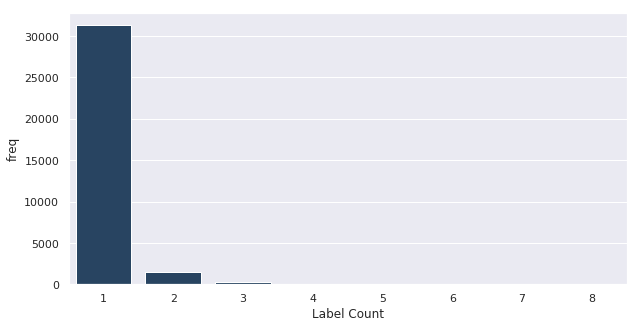

In [0]:
from collections import Counter
class_freq = pd.DataFrame(Counter(y.T.sum()), index=['freq']).T.sort_index(axis=0)
class_freq['Label Count']=class_freq.index
sns.set(rc={'figure.figsize':(10,5)})
sns.barplot(x="Label Count", y="freq", data=class_freq,color='#1e446b')

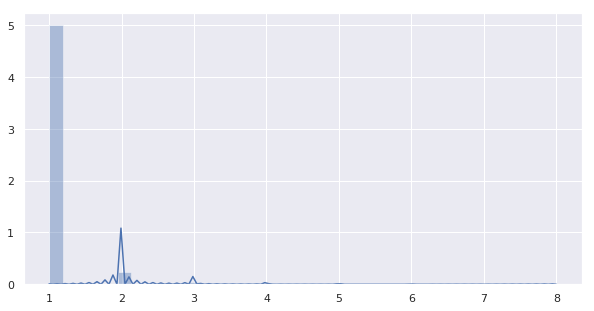

In [0]:
    sns.distplot(y.T.sum(), kde=True,bins=37)

/usr/local/lib/python3.6/dist-packages/seaborn/palettes.py:777: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  pal = _ColorPalette(pal(np.linspace(0, 1, n_colors)))
/usr/local/lib/python3.6/dist-packages/seaborn/palettes.py:777: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  pal = _ColorPalette(pal(np.linspace(0, 1, n_colors)))


Text(0.5, 1.0, 'Top50 Dataset Classes Correlation Matrix')

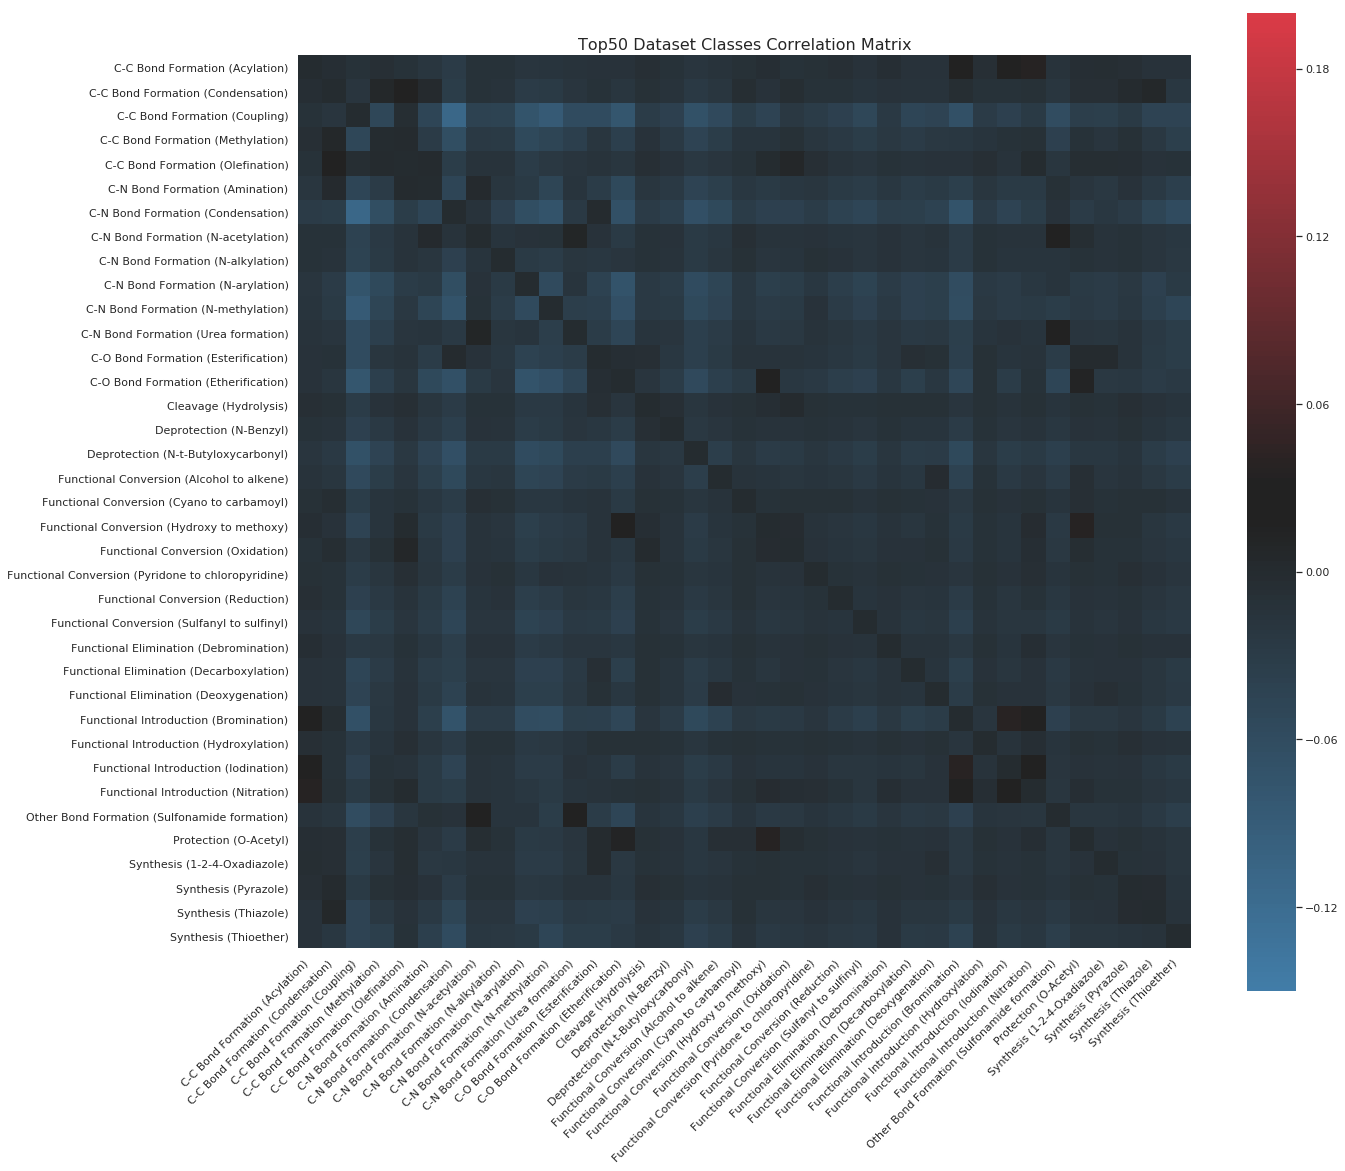

In [0]:
#deprecation
"""
sns.set(rc={'figure.figsize':(20,18)})
ax = sns.heatmap(
    corr, 
    vmin=-0.15, vmax=0.2,
    cmap=sns.diverging_palette(240, 10, n=200, center="dark"),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.title('{} Dataset Classes Correlation Matrix'.format(FINGERPRINT), fontsize=16)
"""

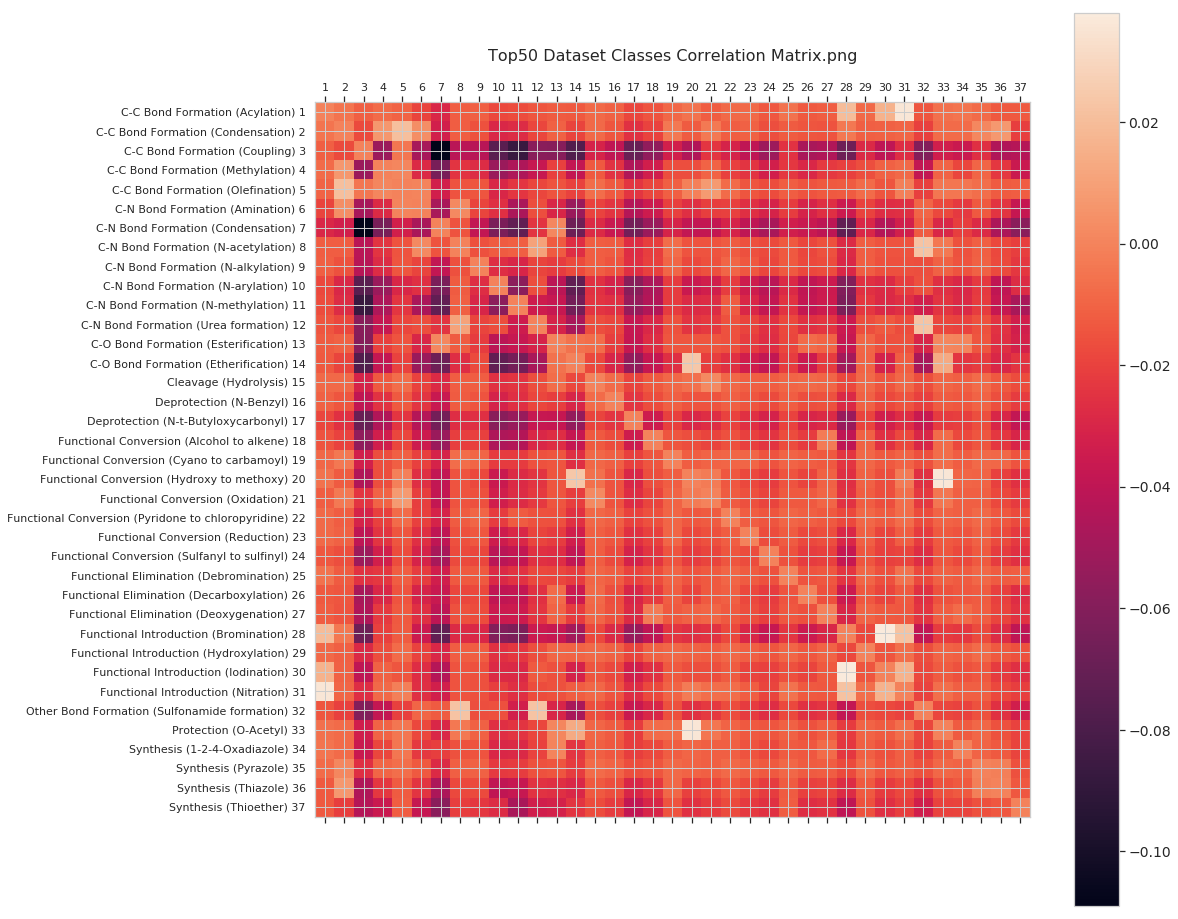

In [0]:
    sns.set(rc={'figure.figsize':(24,20)})
    sns.set(style="whitegrid")
    plt.matshow(corr, )
    plt.xticks(range(corr.shape[1]), class_code['no'])
    plt.yticks(range(corr.shape[1]), class_code['classes']+' '+class_code['no'].map(str))
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('{} Dataset Classes Correlation Matrix.png'.format(FINGERPRINT), fontsize=16);

    plt.show()
    print("\n")

# Classes Relation

In [0]:
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
from skmultilearn.cluster import NetworkXLabelGraphClusterer
FRINGERPRINTS = ["Top5", "Top10", "Top15", "Top20", "Top25", "Top50"]
# FRINGERPRINTS = [ 'FCFP0', 'FCFP2', 'FCFP4']  # for FCFP

for FINGERPRINT in FRINGERPRINTS:
  PATH = "{0}_Fingerprint".format(FINGERPRINT) 
#   PATH = "CDK-{0}".format(FINGERPRINT) #  For FCFP file
  df = pd.read_csv("{0}/{1}.csv.gz".format(PATH,FINGERPRINT), compression='gzip')  
#   df = pd.read_csv("{0}/{1}.csv".format(PATH,FINGERPRINT))  # For FCFP file
  df = df.reindex(sorted(df.columns), axis=1) # sort columns by name
  print("Loading {}...".format(FINGERPRINT))

  np.random.seed(0) 
  X = df.filter(like='bit', axis=1)
  y = df[df.columns.drop(list(df.filter(regex='bit|StringFP|row ID')))] 

  graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)
  edge_map = graph_builder.transform(np.array(y))

  clusterer = NetworkXLabelGraphClusterer(graph_builder, method='louvain')
  partition = clusterer.fit_predict(np.array(X),np.array(y))

  weights = [edge_map[i] for i in clusterer.graph_.edges]

  membership_vector = {member:partition_id for partition_id, members in enumerate(partition) for member in members}

  sns.set(rc={'figure.figsize':(12,12)})
  nx.draw_networkx(
      clusterer.graph_,
      pos=nx.circular_layout(clusterer.graph_),
      labels=pd.Series(range(1,38)),
  #     labels=dict(enumerate([n for l in partition for n in l])),
      with_labels = True,
  # manully get weight : edge_map[i] for i in clusterer.graph_.edge]
  # clusterer.weights_['weight']
      width = [300*w/y.shape[0] for w in weights], # FCFP0:3*w/y.shape[0] OTHERS: 300*w/y.shape[0] Top: w*w/y.shape[0]
      node_color = [membership_vector[i] for i in range(y.shape[1])],
      cmap=plt.cm.Spectral,
      node_size=900,
      font_size=25
  )
  plt.legend(['Class','Relation'],loc='best', fontsize=20)
  plt.title('{} Dataset Reaction Classes Relations'.format(FINGERPRINT), fontsize=23);
  plt.show()